In [67]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import scripts.statistics as stats
import scripts.get_namelist as nml
from scripts.common import *
    
directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr7/1024x1448x512/'
inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
y = np.linspace(Ly/2.,-Ly/2.,Ny)

flist = glob.glob(directory+"*lscale_rr*")
flist.sort()
print([f.split('/')[-1] for f in flist])


Params for this run:
	Mc = 0.2
	Re = 1000.0
	rr = 7.0
Params for this grid:
	N = 1024x1448x512
	L = 150.0x200.0x75.0
['shearlayer_lscale_rr_0021.dat', 'shearlayer_lscale_rr_0022.dat', 'shearlayer_lscale_rr_0023.dat', 'shearlayer_lscale_rr_0024.dat', 'shearlayer_lscale_rr_0025.dat', 'shearlayer_lscale_rr_0026.dat', 'shearlayer_lscale_rr_0027.dat', 'shearlayer_lscale_rr_0028.dat', 'shearlayer_lscale_rr_0058.dat', 'shearlayer_lscale_rr_0059.dat', 'shearlayer_lscale_rr_0060.dat', 'shearlayer_lscale_rr_0061.dat', 'shearlayer_lscale_rr_0062.dat', 'shearlayer_lscale_rr_0063.dat', 'shearlayer_lscale_rr_0064.dat', 'shearlayer_lscale_rr_0065.dat', 'shearlayer_lscale_rr_0066.dat', 'shearlayer_lscale_rr_0067.dat', 'shearlayer_lscale_rr_0068.dat', 'shearlayer_lscale_rr_0069.dat', 'shearlayer_lscale_rr_0070.dat']


/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr7/1024x1448x512/
L/L99 mean, std: [0.164261165417, 0.0142785679331]


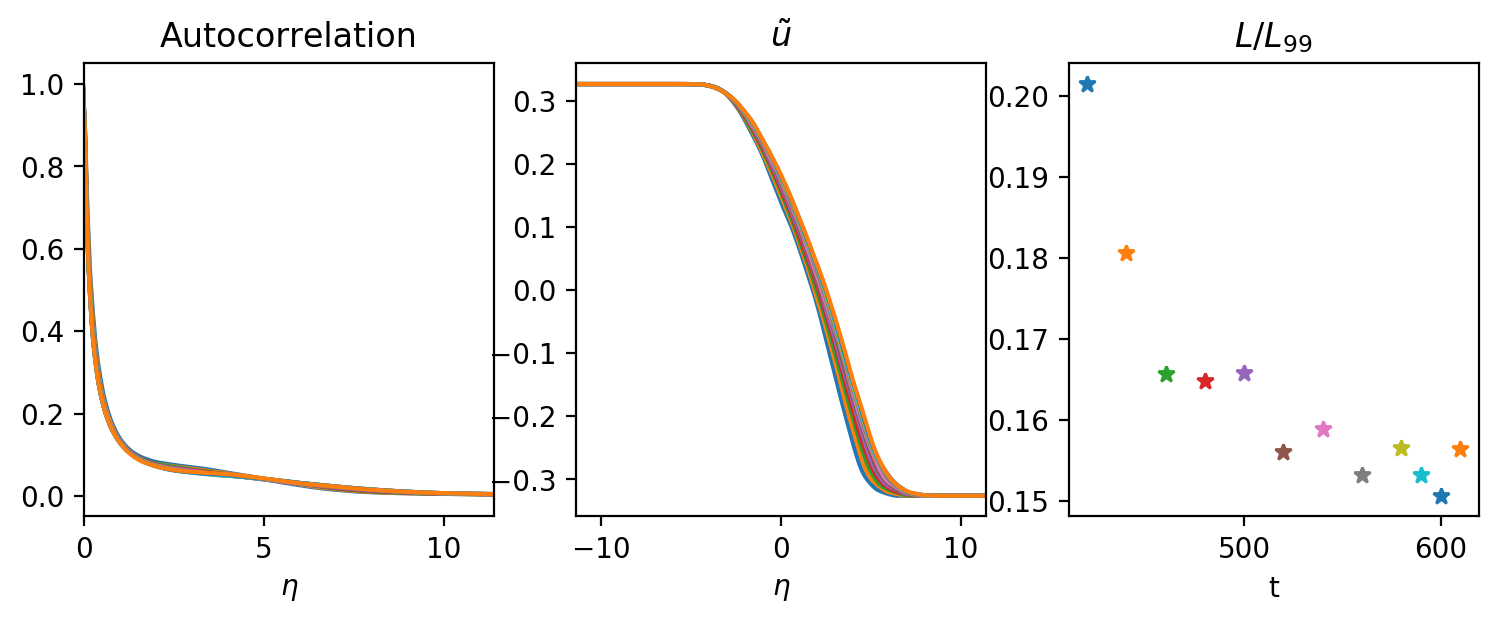

In [68]:
# vv correlation profiles
fig,ax = plt.subplots(1,3,figsize=(9,3), dpi=200)

flist_plot = flist[:-9]
lscales = np.zeros(len(flist_plot))

for count,fname in enumerate(flist_plot):
    tID = fname.split('_')[-1]
    tID = tID.split('.dat')[0]
    time = nml.read_time(directory,tID)
    
    # Get eta
    dtheta = get_dtheta(directory,time)
    eta = y/dtheta
    
    # Get integral lengthscale
    dat = np.fromfile(fname,dtype=float, count=-1, sep=' ')
    autocorr = np.fft.fftshift(dat)
    L_int = get_lscale(y,autocorr)
    ax[0].plot(eta, autocorr, alpha=1,label='t=%d'%time)
    
    # Get 99% lengthscale
    utilde = np.fromfile( directory + 'shearlayer_utilde_'+str(tID)+'.dat',dtype=float, count=-1, sep=' ')
    L99,tmp1,tmp2 = get_L99(y,utilde)
    ax[1].plot(eta, utilde, alpha=1)
    ax[2].plot(time,L_int/L99,'*',label='t=%d'%time)
    
    # Record for later
    lscales[count] = L_int/L99

    
# ax[2].legend()
xmax = L99/dtheta
ax[0].set_xlim([0.,xmax])
ax[1].set_xlim([-xmax,xmax])
ax[0].set_xlabel(r'$\eta$')
ax[1].set_xlabel(r'$\eta$')
ax[2].set_xlabel('t')
ax[0].set_title('Autocorrelation')
ax[1].set_title(r'$\tilde{u}$')
ax[2].set_title('$L/L_{99}$')

istart = 0
ie = -1
print(directory)
print("L/L99 mean, std: [{}, {}]".format(np.mean(lscales[istart:ie]),np.std(lscales[istart:ie])))

fig.savefig(directory+'/img/lscale_r.png',dpi=200, bbox_inches='tight')

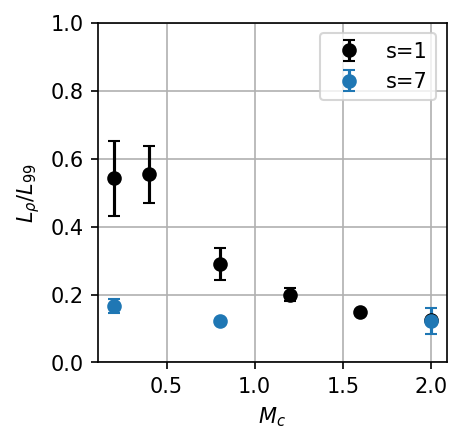

In [64]:

Lvv = {
    0.2: [0.541672152334, 0.111501516089],
    0.4: [0.553669858763, 0.0829374719933],
    0.8: [0.288949608578, 0.0475759908797],
    1.2: [0.199997138673, 0.0204961865692],
    1.6: [0.147681704327, 0.00780050517639],
    2.0: [0.124845271698, 0.00299994653843]}
Lvv_rr7 = {
    0.2: [0.165624520452, 0.0142765242956],
    0.8: [0.121065187206, 0.00269132556636],
    2.0: [0.122391750646, 0.0263222081531]
}
Lvv_rr_7 = {
    0.2: [0.165624520452, 0.0142765242956],
    0.8: [0.121065187206, 0.00269132556636],
    2.0: [0.122391750646, 0.0263222081531]
}

def merge_dicts(old1,old2):
    new = {}
    for i in range(3):
        key = old1.keys()[i]
        v1 = old1.values()[i][0]
        v2 = old2.values()[i][0]
        e1 = old1.values()[i][1]
        e2 = old2.values()[i][1]
        err = np.std([v1,v2]) + (e1**2+e2**2)**0.5
        new[key] = [(v1+v2)/2., err]
    return new

rr = merge_dicts(Lvv_rr7,Lvv_rr_7)

fig = plt.figure(figsize=(3,3),dpi=150)
plt.errorbar(Lvv.keys(),[x[0] for x in Lvv.values()], yerr=[x[1] for x in Lvv.values()],fmt='ko',label='s=1',capsize=3)
# plt.errorbar([k+0.02 for k in Lvv_rr7.keys()],[x[0] for x in Lvv_rr7.values()], yerr=[x[1] for x in Lvv_rr7.values()],fmt='o',label='s=7',capsize=3)
# plt.errorbar([k-0.02 for k in Lvv_rr_7.keys()],[x[0] for x in Lvv_rr_7.values()], yerr=[x[1] for x in Lvv_rr_7.values()],fmt='o',label='s=1/7',capsize=3)
plt.errorbar(rr.keys(),[x[0] for x in rr.values()], yerr=[x[1] for x in rr.values()],fmt='o',label='s=7',capsize=3)


plt.legend()
plt.grid(True)
plt.xlabel(r'$M_c$')
plt.ylabel(r'$L_{\rho}/L_{99}$')
plt.ylim([0,1])
plt.savefig('/home/kmatsuno/ShearLayer_img/lscale_r.png',dpi=200, bbox_inches='tight')